# Solving an XOR classification problem

Example from chapter 13 in the book.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Create data
```
XOR(True, True)   = False
XOR(True, False)  = True
XOR(False, True)  = True
XOR(False, False) = False
```

200


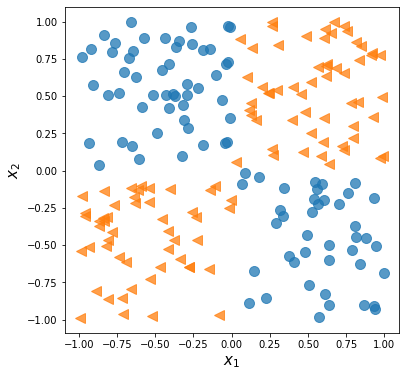

In [2]:
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x)) # size (200,)
print(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], 
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], 
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)

plt.show()

## Create the data loader object

In [3]:
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(x_train, y_train.view(-1,1))

batch_size = 4
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
x,y = next(iter(train_dl))

print(x)

tensor([[ 0.6041,  0.3553],
        [ 0.5186,  0.5957],
        [ 0.7951,  0.2180],
        [-0.8346, -0.1350]])


## Create neural network

In [4]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
)

model

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

## Loss function and optimizer

In [5]:
loss_fn = nn.BCEWithLogitsLoss() # Binary cross entropy loss 
optimizer = torch.optim.SGD(model.parameters(), lr=0.015) # Stochastic gradient decent

In [6]:
a = [0]*6

print(a)

[0, 0, 0, 0, 0, 0]


## Training step

In [7]:
torch.manual_seed(1)
num_epochs = 500
def train(model, num_epochs, train_dl, x_valid, y_valid):
    
    # Create lists with the right length (number of training epochs)
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        
        # Train the network in batches
        for x_batch, y_batch in train_dl:
            
            # Evaluate the network on the current batch
            pred = model(x_batch) # In shape: [4,2], out shape: [4, 1]
            
            # Compute the loss
            loss = loss_fn(pred, y_batch)
            
            # Compute the gradients
            loss.backward()
            
            # Make one step with the optimization proceedure
            optimizer.step()
            
            # Set the gradient to zero (otherwise the next time, you call backward()
            # the previous and current graidents are added)
            optimizer.zero_grad()
            
            # Store training statistics
            loss_hist_train[epoch] += loss.item()
            is_correct = ((torch.sigmoid(pred)>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= (n_train/batch_size)
        accuracy_hist_train[epoch] /= (n_train/batch_size)

        # Check the accuracy/loss on the validation data
        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((torch.sigmoid(pred)>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

## Plot training statistics

Text(0.5, 0, 'Epochs')

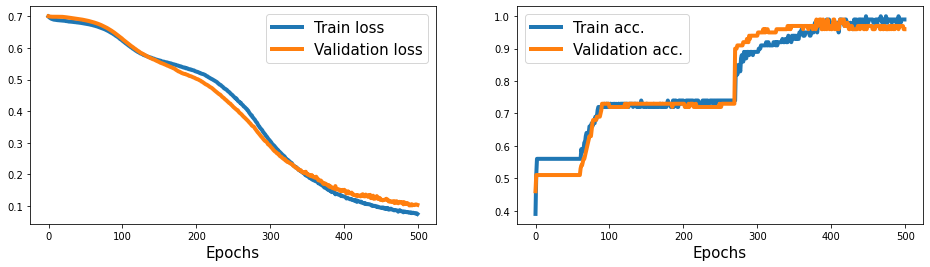

In [8]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

#plt.savefig('figures/13_03.png', dpi=300)

## Making model building more flexible with nn.Module



In [9]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2, 4)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)

    def forward(self, x):
        x = self.l1(x)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (torch.sigmoid(pred)>=0.5).float()
            
model = MyModule()
model


MyModule(
  (l1): Linear(in_features=2, out_features=4, bias=True)
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss() # Binary cross entropy loss 
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
    
history = train(model, num_epochs, train_dl, x_valid, y_valid)

In [ ]:
from mlxtend.plotting import plot_decision_regions


fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

#plt.savefig('figures/13_05.png', dpi=300)
plt.show()